In [1]:
from copy import deepcopy

import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim
from mlx.nn.losses import cross_entropy

import numpy as np
from src.utils import load_data, prepare_dataset
from src.globals import config
from src.visualization import visualize_embedding_tSNE

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
features, labels, adj, edges = load_data(config)

Loading Cora dataset...
Dataset loaded.


/Users/tb/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/mlx-GCN/src/utils.py:79: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:607.)
  matrix = torch.sparse.FloatTensor(indices, data, shape)


In [3]:
NUM_CLASSES = int(labels.max().item() + 1)
train_set_ind, val_set_ind, test_set_ind = prepare_dataset(labels, NUM_CLASSES, config)

## Convert tensors to MLX arrays

In [4]:
features = mx.array(features.numpy())
labels = mx.array(labels.numpy())
adj = mx.array(adj.numpy())
edges = mx.array(edges)

train_set_ind = mx.array(train_set_ind)
val_set_ind = mx.array(val_set_ind)
test_set_ind = mx.array(test_set_ind)

In [5]:
print(features.shape)
print(labels.shape)
print(adj.shape)
print(edges.shape)

[2708, 1433]
[2708]
[2708, 2708]
[5429, 2]


In [31]:
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias)

    def __call__(self, x, adj):
        x = self.linear(x)
        return adj @ x


class GCN(nn.Module):
    def __init__(self, x_dim, h_dim, out_dim, nb_layers=2, dropout=0.5, bias=True):
        super(GCN, self).__init__()

        layer_sizes = [x_dim] + [h_dim] * nb_layers + [out_dim]
        self.gcn_layers = [
            GCNLayer(in_dim, out_dim, bias)
                for in_dim, out_dim in zip(layer_sizes[:-1], layer_sizes[1:])
        ]
        self.dropout = nn.Dropout(p=dropout)

    def __call__(self, x, adj):
        for layer in self.gcn_layers[:-1]:
            x = nn.relu(layer(x, adj))
            x = self.dropout(x)
        
        x = self.gcn_layers[-1](x, adj)
        return x

In [38]:
gcn = GCN(features.shape[1], config.hidden_dim, NUM_CLASSES)

def loss_fn(x, y, weight_decay=0.):
    l = mx.mean(nn.losses.cross_entropy(x, y))

    if weight_decay != 0.:
        l2_reg = mx.zeros(1,)
        for k1, v1 in gcn.parameters().items():
            for k2, v2 in v1.items():
                l2_reg += mx.sum(v2['weight'] ** 2)
        return l + weight_decay * l2_reg.item()
    return l

def eval_fn(x, y):
    return mx.mean(mx.argmax(x, axis=1) == y)

In [39]:
def forward_fn(x, adj, labels):
    y_hat = gcn(x, adj)
    loss = loss_fn(y_hat[train_set_ind], labels[train_set_ind])
    return loss, y_hat

In [40]:
mx.eval(gcn.parameters())

optimizer = optim.Adam(learning_rate=config.lr)
loss_and_grad_fn = nn.value_and_grad(gcn, forward_fn)

In [41]:
(loss, outputs), grads = loss_and_grad_fn(features, adj, labels)

array([0, 0, 0, ..., 6, 6, 6], dtype=int64)
array([[0.000687591, -0.00309797, 0.000939183, ..., 0.00212148, 0.00368854, 0.00294438],
       [-0.000348199, -0.00166191, -0.00261691, ..., 0.0028006, -0.00151213, -0.00136504],
       [0.00220801, -0.00295457, -0.00316691, ..., 0.00262349, 0.00071562, 0.000113961],
       ...,
       [0.000289609, -0.00377145, 4.8318e-05, ..., 0.00225996, 0.00282489, 0.00326607],
       [-0.000687521, -0.00227378, -0.000709211, ..., 0.00326006, 0.00100772, 0.00167228],
       [0.000534144, -0.00320284, 0.000621889, ..., 0.00165159, 0.00328311, 0.00306084]], dtype=float32)


In [42]:
best_val_loss = float('inf')
cnt = 0

for epoch in range(config.epochs):

    # Train
    (loss, y_hat), grads = loss_and_grad_fn(features, adj, labels)
    optimizer.update(gcn, grads)
    mx.eval(gcn.parameters(), optimizer.state)

    # Validation
    val_loss = loss_fn(y_hat[val_set_ind], labels[val_set_ind])
    val_acc =  eval_fn(y_hat[val_set_ind], labels[val_set_ind])

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        cnt = 0
        gcn.save_weights("best_model.npz")
    else:
        cnt += 1
        if cnt == config.patience:
            break
    
    print(" | ".join([f"Epoch: {epoch:3d}", f"Train loss: {loss.item():.3f}",
        f"Val loss: {val_loss.item():.3f}",
        f"Val acc: {val_acc.item():.2f}"]))

array([0, 0, 0, ..., 6, 6, 6], dtype=int64)
array([[-0.000223801, -0.00250956, -0.002487, ..., 0.00202815, -0.000653614, 0.00169049],
       [-0.00138103, -0.00350795, -0.00286192, ..., 0.00542566, 0.000557393, 0.00164638],
       [0.00488127, -0.00209414, -0.00434898, ..., 0.00109023, -0.00125977, -0.00313272],
       ...,
       [0.00159634, -0.00262794, -0.00306148, ..., 0.0041208, 0.000923373, -5.79923e-05],
       [0.000138214, -0.000277378, -0.00249413, ..., 0.00303944, -0.000356778, -0.00110396],
       [0.00214446, -0.000908286, -0.003681, ..., 0.00268166, -0.00036265, -0.00194657]], dtype=float32)
array([3, 3, 3, ..., 5, 2, 5], dtype=int64)
array([[0.000641051, 0.00882304, -0.00175313, ..., 0.00252561, -0.00061861, -0.00458462],
       [0.00293437, -0.00269383, -0.00451074, ..., 0.00526858, 0.00176989, -0.00651309],
       [-0.000485057, -0.00334576, -0.00211841, ..., 0.00618262, 0.00110394, -0.000690593],
       ...,
       [-0.00144359, -0.0008443, -0.00228023, ..., 0.005610

In [37]:
# gcn.load_weights("best_model.npz")

test_y_hat = gcn(features, adj)
test_loss = loss_fn(y_hat[test_set_ind], labels[test_set_ind])
test_acc =  eval_fn(y_hat[test_set_ind], labels[test_set_ind])

print(f"Test loss: {test_loss.item():.3f}  |  Test acc: {test_acc.item():.2f}")

Test loss: 1.910  |  Test acc: 0.69


Text(0.5, 1.0, 't-SNE projection of the learned features')

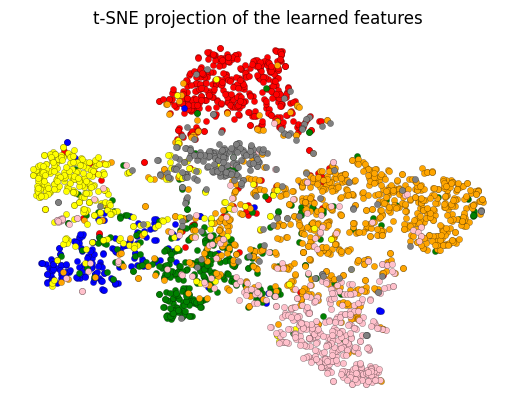

In [13]:
cora_label_to_color_map = {0: "red", 1: "blue", 2: "green",
                           3: "orange", 4: "yellow", 5: "pink", 6: "gray"}

t_sne_embeddings = TSNE(n_components=2, perplexity=30, method='barnes_hut').fit_transform(np.array(test_y_hat.tolist()))

plt.figure()
for class_id in range(NUM_CLASSES):
    plt.scatter(t_sne_embeddings[labels == class_id, 0],
                t_sne_embeddings[labels == class_id, 1], s=20,
                color=cora_label_to_color_map[class_id],
                edgecolors='black', linewidths=0.15)

plt.axis("off")
plt.title("t-SNE projection of the learned features")
    